<a href="https://colab.research.google.com/github/romirahmanw112/BigData2/blob/main/Praktek_big_data_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark findspark -q

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("PraktikumStatistikDeskriptif") \
    .getOrCreate()

print(spark)


In [ ]:
import seaborn as sns

# Load dataset ke Pandas DataFrame
pandas_df = sns.load_dataset('diamonds')

print(f"Jumlah baris data: {len(pandas_df)}")
pandas_df.head()


Jumlah baris data: 53940


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
# Konversi ke Spark DataFrame
df = spark.createDataFrame(pandas_df)

# Tampilkan 5 baris pertama
df.show(5)

# Lihat tipe data tiap kolom
df.printSchema()


+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|   Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|   Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows
root
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: long (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [ ]:
df.describe().show()

+-------+------------------+---------+-----+-------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|             carat|      cut|color|clarity|             depth|            table|             price|                 x|                 y|                 z|
+-------+------------------+---------+-----+-------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|             53940|    53940|53940|  53940|             53940|            53940|             53940|             53940|             53940|             53940|
|   mean|0.7979397478679908|     NULL| NULL|   NULL|61.749404894327284|57.45718390804599| 3932.799721913237|  5.73115721171672| 5.734525954764569| 3.538733778272195|
| stddev|0.4740112444054214|     NULL| NULL|   NULL|1.4326213188336532|2.234490562821348|3989.4397381463846|1.1217607467924988|1.1421346741235596|0.7056988469499972|
|   

In [ ]:
from pyspark.sql.functions import mean, stddev, variance, min, max, col

price_stats = df.select(
    mean(col("price")).alias("mean_price"),
    stddev(col("price")).alias("stddev_price"),
    variance(col("price")).alias("variance_price"),
    min(col("price")).alias("min_price"),
    max(col("price")).alias("max_price")
)

price_stats.show()


+-----------------+------------------+--------------------+---------+---------+
|       mean_price|      stddev_price|      variance_price|min_price|max_price|
+-----------------+------------------+--------------------+---------+---------+
|3932.799721913237|3989.4397381463846|1.5915629424301494E7|      326|    18823|
+-----------------+------------------+--------------------+---------+---------+



In [ ]:
from pyspark.sql.functions import desc

mode_cut = df.groupBy("cut") \
    .count() \
    .orderBy(desc("count"))

mode_cut.show(1)


+-----+-----+
|  cut|count|
+-----+-----+
|Ideal|21551|
+-----+-----+
only showing top 1 row


In [ ]:
# Median aproksimasi (cepat)
median_price = df.approxQuantile("price", [0.5], 0.01)
print("Median price (aproksimasi):", median_price[0])


Median price (aproksimasi): 2387.0


In [ ]:
sampled_df = df.sample(
    withReplacement=False,
    fraction=0.1,
    seed=42
)

viz_df = sampled_df.toPandas()

print("Jumlah data sampel:", len(viz_df))


Jumlah data sampel: 5459


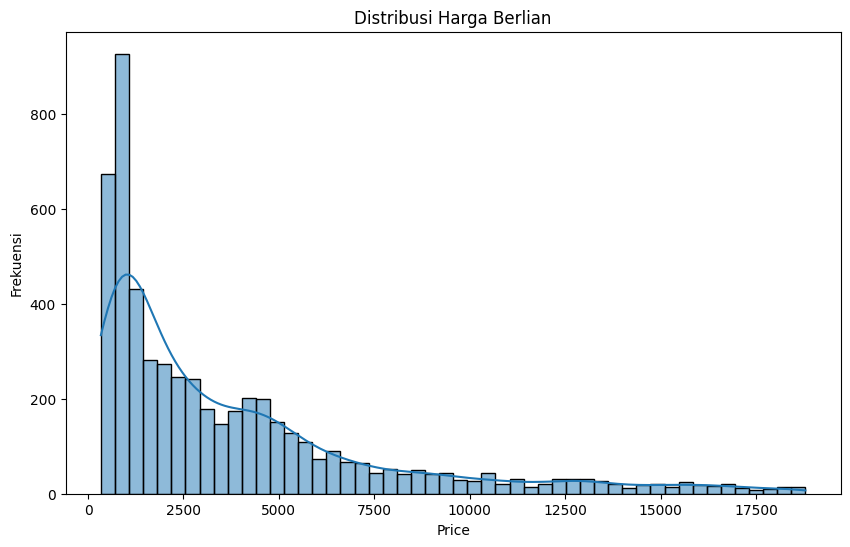

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(viz_df['price'], bins=50, kde=True)
plt.title("Distribusi Harga Berlian")
plt.xlabel("Price")
plt.ylabel("Frekuensi")
plt.show()


In [ ]:
from pyspark.sql.functions import skewness

df.select(skewness("price").alias("skewness_price")).show()


+------------------+
|    skewness_price|
+------------------+
|1.6183502776052823|
+------------------+



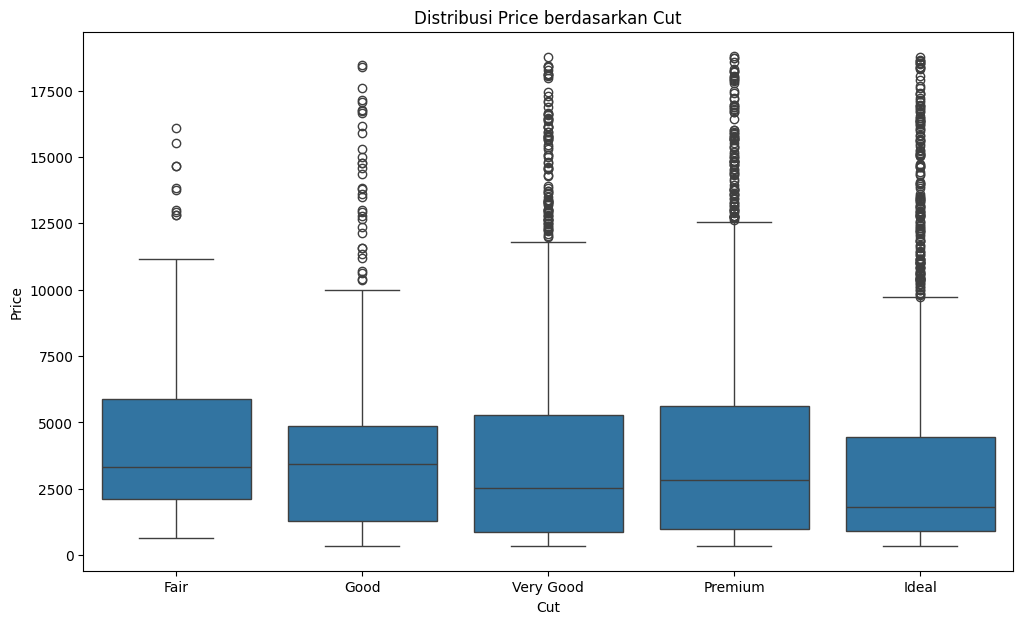

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(
    data=viz_df,
    x='cut',
    y='price',
    order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
)
plt.title("Distribusi Price berdasarkan Cut")
plt.xlabel("Cut")
plt.ylabel("Price")
plt.show()
